In [7]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP, AutoEncoder, VariationalAutoEncoder
from micrograd.loss_funcs import mean_squared_error, vae_loss
from micrograd.optimizer import SGD
from micrograd.batch_iterator import BatchIterator
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [8]:
X = load_digits()

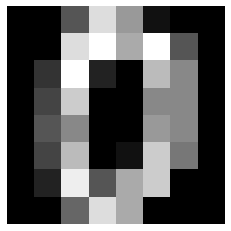

In [9]:
def display_image_on_ax(X, ax):
    # Pass X as a 64-element array
    rearranged = np.reshape(X, (8, 8))
    ax.imshow(rearranged, cmap='gray')
    ax.axis('off')

# 1. Create a Figure and a single Axes object (ax)
fig, ax = plt.subplots(nrows=1, ncols=1) 

# 2. Call the function, providing both arguments
display_image_on_ax(X.data[0], ax)

# 3. Show the plot
plt.show()


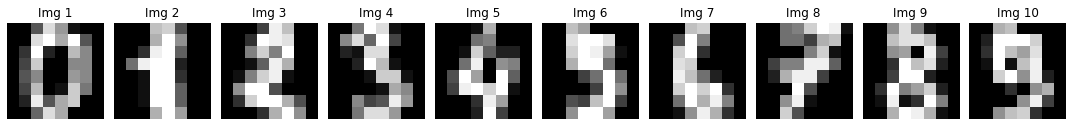

In [10]:
num_images_to_display = 10

# Create a figure and a set of subplots (1 row, 10 columns)
fig, axes = plt.subplots(nrows=1, ncols=num_images_to_display, figsize=(15, 2))

for k in range(num_images_to_display):
    display_image_on_ax(X.data[k], axes[k])
    
    axes[k].set_title(f"Img {k+1}")

plt.tight_layout()
plt.show()

In [11]:
t = MinMaxScaler()

t.fit(X.data)

X_train = t.transform(X.data)

X_train_values = [[Value(v) for v in sample] for sample in X_train]

target_values = X_train_values

In [9]:
auto = AutoEncoder(in_embeds=64, latent_dim=8, act_func=Value.sigmoid, tied=True) 
optimizer = SGD(auto.parameters(), learning_rate=0.5)

train = X_train_values[:10]
target = target_values[:10]
historical_loss = []
for i in range(500):
    optimizer.zero_grad()
    
    
    # reconstruction = map(Value, single_test)
    
    # score = auto(reconstruction)
    
    scores_values = [auto(x) for x in train]
    
    # loss = mean_squared_error(target, score)
    
    loss = sum([mean_squared_error(targ, pred) for targ, pred in zip(target, scores_values)])
    historical_loss.append(loss)
    
    loss.backward()
    
    optimizer.step()

    if i % 50 == 0:
        print(f"Iteration : {i}, AutoEncoder Loss: {loss.data:.12f}")




Iteration : 0, AutoEncoder Loss: 2.704334726619
Iteration : 50, AutoEncoder Loss: 0.628993223218
Iteration : 100, AutoEncoder Loss: 0.310866748142
Iteration : 150, AutoEncoder Loss: 0.211498856448
Iteration : 200, AutoEncoder Loss: 0.165693879349
Iteration : 250, AutoEncoder Loss: 0.134754877342
Iteration : 300, AutoEncoder Loss: 0.117352467448
Iteration : 350, AutoEncoder Loss: 0.103281565768
Iteration : 400, AutoEncoder Loss: 0.096147140625
Iteration : 450, AutoEncoder Loss: 0.090046164055


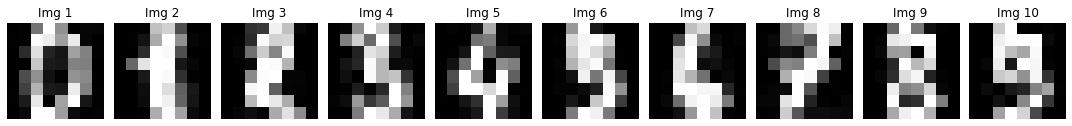

In [10]:
hey = [np.array([i.data for i in j]) for j in scores_values]


# The 'hey' array likely already has the 64 features needed for a single sample
# We reshape it to (1, 64) for the inverse_transform method
formatted_for_scaler = [i.reshape(1, 64) for i in hey]




# Create a figure and a set of subplots (1 row, 10 columns)
fig, axes = plt.subplots(nrows=1, ncols=num_images_to_display, figsize=(15, 2))

for k in range(num_images_to_display):
    # Inverse transform to get data back to 0-16 scale
    unscaled_1d = t.inverse_transform(formatted_for_scaler[k])
    
    # Flatten it to a 64-element array to match your function's input expectation
    image_data_64 = unscaled_1d.flatten() 
    
    # Use the modified function, passing the specific axis object
    display_image_on_ax(image_data_64, axes[k])
    
    axes[k].set_title(f"Img {k+1}")

plt.tight_layout()
plt.show()

In [6]:
# Create a simple VAE
vae = VariationalAutoEncoder(
    in_embeds=64,    # Input dimension
    latent_dim=4,        # Latent space dimension
    act_func=Value.sigmoid,       # Activation function (None uses default leaky_relu)
    tied=True           # Whether to use tied weights
)

optimizer = SGD(vae.parameters(), learning_rate=0.3)

# Example input (list of Values)
train = X_train_values[:10]
target = target_values[:10]
historical_loss_vae = []
for i in range(200): # Run more iterations for VAE convergence (adjust as needed)
    optimizer.zero_grad()
    
    # 1. Forward pass for the entire dataset
    # This generates a list of tuples: [(recon1, mu1, lv1), (recon2, mu2, lv2), ...]
    all_sample_outputs = [vae(x) for x in train]
    
    # 2. Calculate the loss for each sample and sum them up
    sample_losses = []
    for sample_idx, (reconstruction, mu, log_var) in enumerate(all_sample_outputs):
        target_sample = target[sample_idx]
        
        # Calculate loss for a single sample (your vae_loss function handles single samples)
        loss = vae_loss(reconstruction, target_sample, mu, log_var, beta=1.0)
        sample_losses.append(loss)
    
    # 3. Average the total loss over all samples (Full Batch Gradient Descent)
    total_loss = sum(sample_losses) / len(sample_losses)
    historical_loss_vae.append(total_loss)
    
    # 4. Backward pass and optimization
    total_loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Iteration : {i}, VAE Total Loss: {total_loss.data:.8f}")



Iteration : 0, VAE Total Loss: 6.54652761
Iteration : 10, VAE Total Loss: 0.76814318
Iteration : 20, VAE Total Loss: 0.50120999
Iteration : 30, VAE Total Loss: 0.39797158
Iteration : 40, VAE Total Loss: 0.35009605
Iteration : 50, VAE Total Loss: 0.31448914
Iteration : 60, VAE Total Loss: 0.29885313
Iteration : 70, VAE Total Loss: 0.28354003
Iteration : 80, VAE Total Loss: 0.26963230
Iteration : 90, VAE Total Loss: 0.26330689
Iteration : 100, VAE Total Loss: 0.25916698
Iteration : 110, VAE Total Loss: 0.23106374
Iteration : 120, VAE Total Loss: 0.23870396
Iteration : 130, VAE Total Loss: 0.25764572
Iteration : 140, VAE Total Loss: 0.22810569
Iteration : 150, VAE Total Loss: 0.23205458
Iteration : 160, VAE Total Loss: 0.23335223
Iteration : 170, VAE Total Loss: 0.23345620
Iteration : 180, VAE Total Loss: 0.22072001
Iteration : 190, VAE Total Loss: 0.24156995


In [14]:
vae = VariationalAutoEncoder(
    in_embeds=64,    # Input dimension
    latent_dim=4,        # Latent space dimension
    act_func=Value.sigmoid,       # Activation function (None uses default leaky_relu)
    tied=True           # Whether to use tied weights
)

BATCH_SIZE = 64 
NUM_EPOCHS = 50 

print(f"Starting VAE training with {NUM_EPOCHS} epochs (Batch Size: {BATCH_SIZE}, Shuffling: True)")

# Initialize the iterator once outside the epoch loop, specifying shuffle=True
# We pass the full dataset to the iterator
batch_iterator = BatchIterator(X_train_values[:500], target_values[:500], batch_size=BATCH_SIZE, shuffle=True)
optimizer = SGD(vae.parameters(), learning_rate=0.3)

for epoch in range(NUM_EPOCHS):
    # Iterate through the batches generated by calling the iterator (which handles shuffling starts)
    for batch_inputs, batch_targets in batch_iterator():
        optimizer.zero_grad()

        # Forward pass for the current batch (list of tuples)
        all_sample_outputs = [vae(x_val) for x_val in batch_inputs]
        
        # Calculate individual losses for the samples in the batch
        batch_losses = []
        for sample_idx, (reconstruction, mu, log_var) in enumerate(all_sample_outputs):
            target_sample = batch_targets[sample_idx]
            loss = vae_loss(reconstruction, target_sample, mu, log_var, beta=1.0)
            batch_losses.append(loss)
                # Average loss over the *current batch* only
        batch_loss = sum(batch_losses, Value(0.0)) / len(batch_losses)
        
        # Backward pass and optimization step (weights are updated)
        batch_loss.backward()
        optimizer.step()
    
    # Print progress at the end of each epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Last Batch Loss: {batch_loss.data:.8f}")


Starting VAE training with 50 epochs (Batch Size: 64, Shuffling: True)
Epoch 1/50, Last Batch Loss: 0.98768140
Epoch 2/50, Last Batch Loss: 0.81204035
Epoch 3/50, Last Batch Loss: 0.66512992
Epoch 4/50, Last Batch Loss: 0.60126860
Epoch 5/50, Last Batch Loss: 0.49746203
Epoch 6/50, Last Batch Loss: 0.49923083
Epoch 7/50, Last Batch Loss: 0.50111408
Epoch 8/50, Last Batch Loss: 0.50191262
Epoch 9/50, Last Batch Loss: 0.46532090
Epoch 10/50, Last Batch Loss: 0.46154164
Epoch 11/50, Last Batch Loss: 0.42504374
Epoch 12/50, Last Batch Loss: 0.39730348
Epoch 13/50, Last Batch Loss: 0.40142603
Epoch 14/50, Last Batch Loss: 0.42839368
Epoch 15/50, Last Batch Loss: 0.42086861
Epoch 16/50, Last Batch Loss: 0.36526759
Epoch 17/50, Last Batch Loss: 0.37817914
Epoch 18/50, Last Batch Loss: 0.37313303
Epoch 19/50, Last Batch Loss: 0.34449884
Epoch 20/50, Last Batch Loss: 0.32660652
Epoch 21/50, Last Batch Loss: 0.33880385
Epoch 22/50, Last Batch Loss: 0.33393196
Epoch 23/50, Last Batch Loss: 0.3234

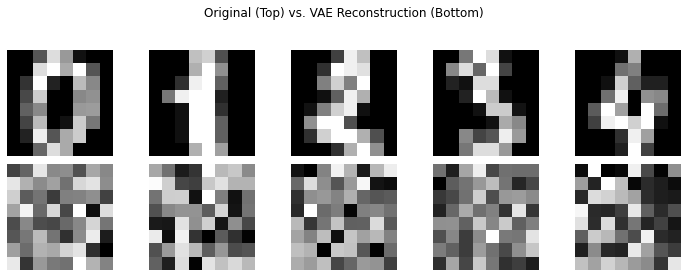

In [16]:
num_samples_to_show = 5
fig, axes = plt.subplots(nrows=2, ncols=num_samples_to_show, figsize=(10, 4))
fig.suptitle("Original (Top) vs. VAE Reconstruction (Bottom)")

for j in range(num_samples_to_show):
    # --- FIX IS HERE ---
    # Convert the list of Value objects into a proper NumPy array of floats
    original_sample_values = X_train_values[j]
    original_sample_np = np.array([v.data for v in original_sample_values])
    
    # Now pass the correct NumPy array to the function
    display_image_on_ax(original_sample_np, axes[0, j])
    # -------------------

    # Reconstructed Data (ensure this is also converted to numpy if you use it later)
    # The reconstruction logic from my previous answer handles this conversion:
    recon_val, _, _ = vae(original_sample_values)
    recon_np = np.array([v.data for v in recon_val])
    
    display_image_on_ax(recon_np, axes[1, j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
plt.show()